# **A/B testing in a videogame**

This project consists of performing an A/B test for two versions of the videogame *Cookie Cats*, a cat-themed puzzle game. In this game, players progress through multiple rounds that must be completed until they reach a 'gate' level, originally placed at level 30. In this test, the gate was placed at level 40 instead for a group of players. The company wants to know whether placing the gate at level 40 had an effect on player retention. This type of study is called an A/B test.

The features of the dataset will  be the following:

* **userid**: key value assigned to each individual player.

* **version**: version of the game assigned to the user. gate_30 has the gate at level 30 and gate_40 has the gate at level 40.

* **Sum_gamerounds**: total number of rounds played after 14 days.

* **retention_1**: categorical feature that tells us whether the player played after the first day.

* **retention_7**: categorical feature that tells us whether the player played after 7 days.

In [385]:
#importing the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

In [386]:
#importing the dataset as a pandas dataframe
df = pd.read_csv('cookie_cats.csv')
print(df.head())

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


## Exploratory Data Analysis

In [387]:
#checking the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


We have 90189 rows, each one representing a player who participated in the test. Looking at the number of entries and the number of non-nulls, we can see that there are no empty values in the dataset.

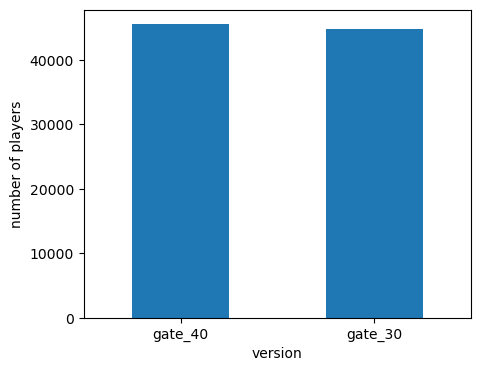

In [388]:
#data balance
plt.figure(figsize=(5,4))
df.version.value_counts().plot(kind='bar')
plt.ylabel('number of players')
plt.xticks(rotation=0);

The number of players in each group is basically the same. This is important for the comparison.

In [389]:
#Players retained after 1 day
print(f'number of players who played more than one day:', df['retention_1'].sum(), 
      f'({round(df.retention_1.sum()/len(df)*100, 2)}%)')
#Players retained after 7 days
print(f'number of players who played more than one day:', df['retention_7'].sum(), 
      f'({round(df.retention_7.sum()/len(df)*100, 2)}%)')

number of players who played more than one day: 40153 (44.52%)
number of players who played more than one day: 16781 (18.61%)


Player retention drastically drops after the first day, with only 44.52% of players continuing to play. It then seems to continue to drop at a slower pace as the days pass because by the end of the first week only 18.61% of the original number of players remain. We can't directly investigate this further because we don't have the number of rounds played each day. We only have the total number of rounds.

In [390]:
#Mean results between versions
print(df[df.columns[1:]].groupby('version').mean())

         sum_gamerounds  retention_1  retention_7
version                                          
gate_30       52.456264     0.448188     0.190201
gate_40       51.298776     0.442283     0.182000


Just by observing the mean results, we can see that the version of the game with the gate at level 30 performed slightly better. Considering that this is the original version, it hints at the fact that the change was not really beneficial. Even if we find that the difference between versions is statistically significant, we can never recommend to change from the original version. However, we will continue with the A/B testing process to confirm whether the original version is truly better.

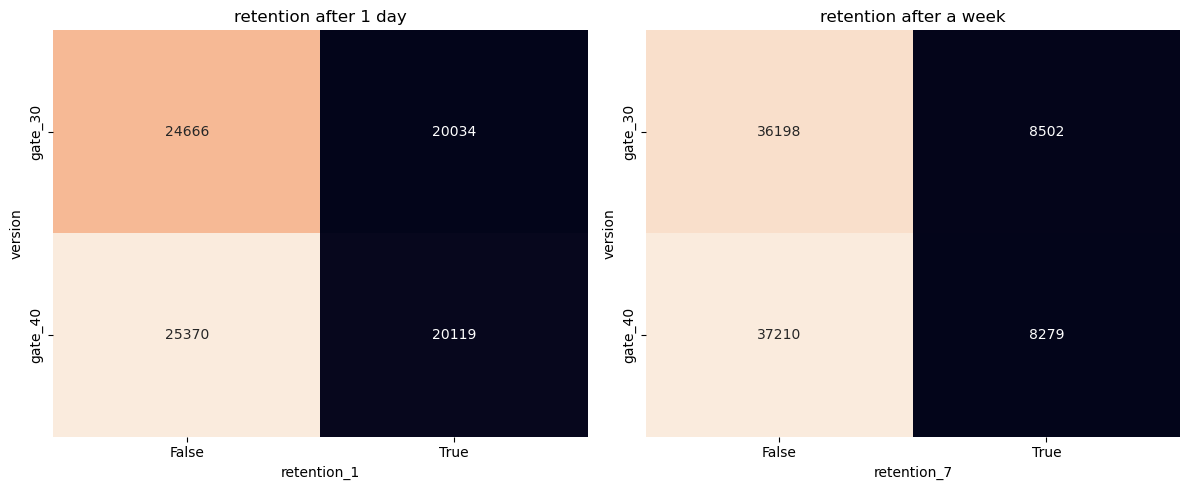

In [391]:
plt.figure(figsize=(12, 5))

#Contingency table of retention after 1 day
plt.subplot(1, 2, 1)
sns.heatmap(pd.crosstab(df.version, df.retention_1), annot=True, fmt='g', cbar=False)
plt.title('retention after 1 day')

#Contingency table of retention after 7 days
plt.subplot(1, 2, 2)
sns.heatmap(pd.crosstab(df.version, df.retention_7), annot=True, fmt='g', cbar=False)
plt.title('retention after a week')

plt.tight_layout();

This plot shows the number of players retained after 1 day and 7 days for each version. In terms of retention after 1 day, we see that the number of players retained is slighly higher for the version with the gate at level 40. However, it must be noted that this version contains about 800 more players than the other version. Because the difference in retention after the first day is so small (only 85 player), we can't be sure that the difference can't be attributed to one sample having more players than the other.

The retention after one week shows a more interesting result. We can see that the version with the gate at level 30 retained more player even though it has fewer players. There might be a significant difference here that is worth exploring.

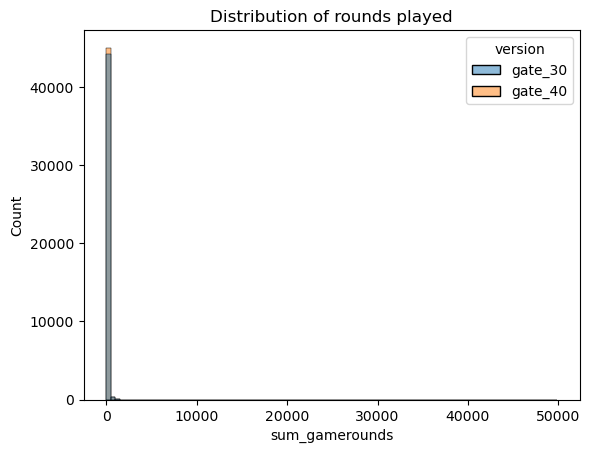

In [392]:
sns.histplot(data= df, x='sum_gamerounds', bins=100, hue='version')
plt.title('Distribution of rounds played');

This distribution tells us that the great majority of players only play a few rounds and then stop playing the game. This is consistent with what was analyzed regarding the percentage of players that retained after 1 and 7 days. We expected that a great number of players would stop playing as time passes.

<Axes: xlabel='sum_gamerounds'>

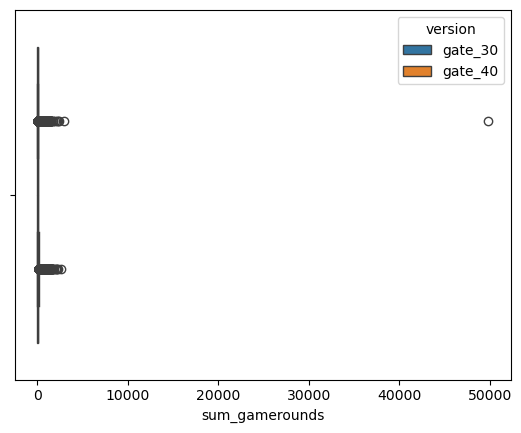

In [393]:
#Box plot of rounds played
sns.boxplot(data= df, x='sum_gamerounds', hue='version')

This box plot shows an interesting outlier for the version with the gate at level 30. One player seems to have played nearly 50 thousand rounds in 14 days. This most likely represents an error. Therefore, the data point will be removed because it might distort the real results.

In [394]:
#Outlier to be treated
df['sum_gamerounds'][df['sum_gamerounds']>3000]

57702    49854
Name: sum_gamerounds, dtype: int64

In [395]:
# There are 3994 participants who never played the game
df['sum_gamerounds'][df['sum_gamerounds'] == 0].count()

3994

It could be said that the participants who played 0 rounds didn't really participate in the test and should be removed. However, we will keep them because the placement of the gate at different levels could, theoretically, make a customer not want to give the game a chance. Therefore, we can't say that their decision was not influenced by the element studied in this A/B test.

## Data Clearning

This segment consists of removing the extreme outlier found previously.

In [396]:
#Removing the extreme outlier found previously
df.drop(df['sum_gamerounds'][df['sum_gamerounds']>3000].index, axis=0, inplace=True)

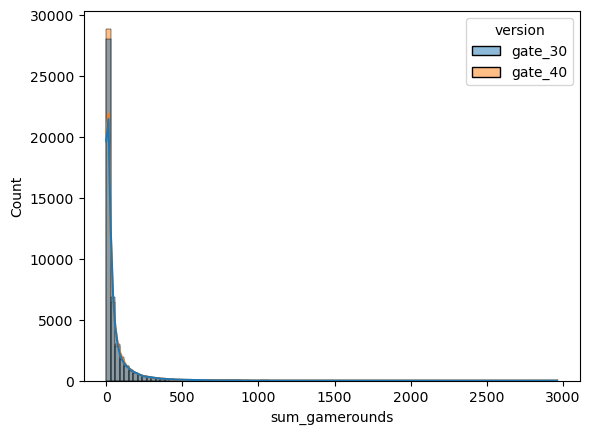

In [397]:
#Distribution after removing the outlier
sns.histplot(data=df, x='sum_gamerounds', bins=100, kde=True, hue='version');

We now get a clearer picture of the distribution of rounds played. We see that both versions follow the same trend, where the number of rounds played decrease sharply.

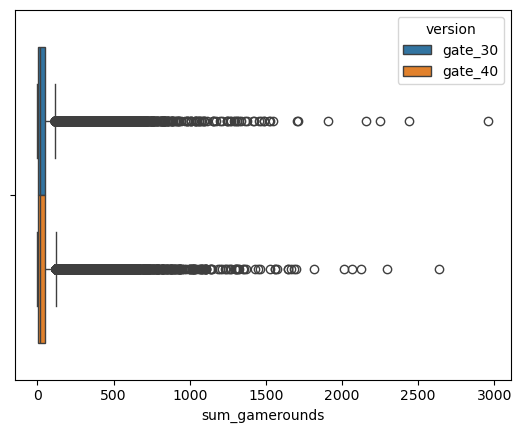

In [398]:
#Box plots after removing the outlier
sns.boxplot(data=df, x='sum_gamerounds', hue='version');

## Hypothesis testing

We want to determine whether there is a significant difference between versions in terms of player retention. For this, we will use a hypothesis test to determine whether there is a statistically significant difference between the means of rounds played between groups. This will be done using a two sample t-test.

The test assumes that the variances between samples is the same and that the distribution is normal. The similarity in variance will be tested with Levene's test, and because of the central limit theorem, the distributions of sample means will follow a normal distribution.

In [399]:
#Mean results of rounds played
print(df[['version','sum_gamerounds']].groupby('version').mean())

         sum_gamerounds
version                
gate_30       51.342111
gate_40       51.298776


We can see that the the version with the gate at the 30th level has a slightly greater mean of rounds played.

In [400]:
#Levene's test
sp.stats.levene(df[df.version == 'gate_30'].sum_gamerounds, df[df.version == 'gate_40'].sum_gamerounds)

LeveneResult(statistic=0.07510153837481241, pvalue=0.7840494387892463)

With a p-value of 0.78, we accept the null hypothesis that the variances between samples is the same.

In [401]:
#two sample t-test
sp.stats.ttest_ind(df[df.version == 'gate_30'].sum_gamerounds, df[df.version == 'gate_40'].sum_gamerounds)

TtestResult(statistic=0.0633675766982082, pvalue=0.9494739458256001, df=90186.0)

With a p-value greater than 0.05, we must accept the null hypothesis at a confidence level of 95%. That is, the mean between versions is not significantly different. This means that there is no real statistical difference between placing the gate at level 30 vs placing it at level 40.

Now, we will test whether the version of the game had an effect on the retention past 1 and 7 days. Since we are dealing with categorical variables, we will use a chi-square test.

In [402]:
#Contingency table of player retention after 1 day
print(pd.crosstab(df.version, df.retention_1))

retention_1  False  True 
version                  
gate_30      24665  20034
gate_40      25370  20119


In [403]:
#Chi-squared test to see if the difference in retention after 1 day is statistically significant
sp.stats.chi2_contingency(pd.crosstab(df.version, df.retention_1))

Chi2ContingencyResult(statistic=3.169835543170799, pvalue=0.07500999897705693, dof=1, expected_freq=array([[24798.35970417, 19900.64029583],
       [25236.64029583, 20252.35970417]]))

With a p-value greater than 0.05, we accept the null hypothesis that there is no statistically significant 

In [404]:
#Contingency table of player retention after 7 days
print(pd.crosstab(df.version, df.retention_7))

retention_7  False  True 
version                  
gate_30      36198   8501
gate_40      37210   8279


In [405]:
#Chi-squared test to see if the difference in retention after 7 days is statistically significant
sp.stats.chi2_contingency(pd.crosstab(df.version, df.retention_7))

Chi2ContingencyResult(statistic=9.91527552890567, pvalue=0.0016391259678654425, dof=1, expected_freq=array([[36382.49203885,  8316.50796115],
       [37025.50796115,  8463.49203885]]))

In this case, with a p-value of 0.001, we have strong evidence for a statistically significant difference between the versions that favours placing the gate at level 30. As we had previously seen on the contingency table for retention at the 7-day point, the version with the gate at level 30 had more cases where players were retained after a week (8501) than the version with the gate at level 40 (8279), even though the former sample has almost 800 cases less than the later. This test demonstrated that the version with the gate at level 30 does lead to more players being retained for a week.

## Conclusion

Two versions of the game *Cookie Cats* were tested, one with the gate level at level 30 and one with the gate level at level 40. After the data was analyzed and tested, it was found that there was no significant difference between the versions in terms of the mean number of rounds played and the retention after the first day. However, it was found that the version with the gate at level 30 provides a statistically significant higher likelyhood of players being retained after a week. This might be due to players progressing through the game normally during the first days and then feeling motivated to continue playing after surpassing the first gate level. Even if they haven't surpassed it, by the end of the first week they might be so close to it that they decide to continue playing to reach the gate level. Therefore, the version **recommended** is the one that places the **gate at level 30**.